In [ ]:
# Importando bibliotecas
import os
import re
import warnings
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from rapidfuzz import process
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

#pd.reset_option("display.max_rows")

# Dados

Os dados utilizados na pesquisa e resultado de informações, de origens publica e restrita tendo como fontes o portal da [**Portal da Tranparência do TJBA**](https://www.tjba.jus.br/transparencia/), [**DataJude**](https://www.cnj.jus.br/sistemas/datajud/) e PJe em parceria com o TJBA.

Diretódio do projeto onde estão os dados:

```
dados
├── DADOS_TJBA_PG.parquet - Arquivo gerado pelo Apache Hop no cruzaemnto de dados do 1º Grau
└── MEMBROS-DO-TJBA-E-AGENTES-PUBLICOS.csv - Arquivo do PT com lista de magistrados e lotação
```

## Dados de Magistrados - Portal da Transparência
Esses dados podem demosntrar quantos magistrados exitem por vara.

In [5]:
# Inportando dados de magistrados do PT
df_magistrados = pd.read_csv('../../dados/MEMBROS_E_AGENTES_PUBLICOS_JUL2025.csv', sep=';')
df_magistrados = df_magistrados[df_magistrados['Cargo'].str.startswith('JUIZ', na=False)]

df_magistrados.head()

,Nome,Matrícula Funcional,Cargo,Função de Confiança/ Cargo em Comissão,Lotação,Ato de Provimento,Data de Publicação
7,ABRAAO BARRETO CORDEIRO,9679782,JUIZ DE DIREITO,NaN,VARA CRIM JURI EXEC PENAIS MEN,PORT S/N,16/09/2013
25,ADALBERTO LIMA BORGES FILHO,9698345,JUIZ DE DIREITO,NaN,JURISDICAO PLENA,PORT S/N,06/10/2021
69,ADERALDO DE MORAIS LEITE JUNIOR,9679871,JUIZ DE DIREITO,NaN,JURISDICAO PLENA,PORT S/N,16/09/2013
73,ADIANE JAQUELINE NEVES DA SILVA OLIVEIRA,9679812,JUIZ DE DIREITO,NaN,1ª VARA DOS SISTEMA DOS JUIZADOS ESPECIAIS,PORT S/N,16/09/2013
74,ADIDA ALVES DOS SANTOS,8098654,JUIZ DE DIREITO,NaN,2ª VARA DA INFANCIA E JUVENTUDE,PORT S/N,01/12/2004


In [6]:
df_magistrados.shape

(621, 7)

In [7]:
df_magistrados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621 entries, 7 to 8846
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Nome                                    621 non-null    object
 1   Matrícula Funcional                     621 non-null    int64 
 2   Cargo                                   621 non-null    object
 3   Função de Confiança/ Cargo em Comissão  0 non-null      object
 4   Lotação                                 621 non-null    object
 5   Ato de Provimento                       621 non-null    object
 6   Data de Publicação                      621 non-null    object
dtypes: int64(1), object(6)
memory usage: 38.8+ KB


In [8]:
# Contagens de Juízes
df_magistrados.Cargo.value_counts()

Cargo
JUIZ DE DIREITO                                      544
JUIZ SUBSTITUTO                                       56
JUIZ SUBSTITUTO DE SEGUNDO GRAU - ENTRANCIA FINAL     21
Name: count, dtype: int64

In [9]:
# Pesquisa por magistrado
df_magistrados[df_magistrados['Nome'] == 'ULYSSES MAYNARD SALGADO']

,Nome,Matrícula Funcional,Cargo,Função de Confiança/ Cargo em Comissão,Lotação,Ato de Provimento,Data de Publicação
8430,ULYSSES MAYNARD SALGADO,8088900,JUIZ DE DIREITO,NaN,1A VARA FAZENDA PUBLICA,PORT S/N,23/12/2002


In [10]:
# Contagem de Lotação
df_magistrados_g = df_magistrados.groupby('Lotação').agg(quant=('Lotação', 'count'))

In [11]:
df_magistrados_g

,quant
Lotação,
1ª VARA CRIM JURI EXEC PENAIS,1
VARA EXEC. PENAIS E MEDIDAS ALTERNATIVAS,1
10ª VARA CIVEL,1
10ª VARA DE FAMILIA,1
10ª VARA DE RELACOES DE CONSUMO,1
...,...
VARA ESP CRIM INFAN JUVEN,1
VARA FEITOS RELATIVOS REL DE CONSUMO CIVEIS E COM,1
VARA FEITOS RELATIVOS REL DE CONSUMO CIVEIS E COM,1


In [12]:
# Vara com maior número de juízes atuantes
df_magistrados_g[df_magistrados_g['quant'] == df_magistrados_g['quant'].max()]

,quant
Lotação,
JURISDICAO PLENA,88


## Cruzamento dos Dados

Nessa fase precisamos cruzar alguns dados, apesar de termos fontes como **CNJ(DataJUD)**, algumas informações são mais específicas e precisamos cruzar essas informações com o TJBA. Nessa primeira etapa devido ao volume e acomplexidade, foi utilizado a ferramenta de ETL [**Apache Hop**](https://hop.apache.org/), para o cruzamento, análises e um tratamento inicial. O artefado final gerado nessa etapa será um arquivo parquet, que usaremos como principal fonte de dados para o modelo.

<p align="center">
    <img width="850" height="250" src="../../img/001.png">
</p>

## Tratamento dos Dados

Aqui vamos trabalhar com os dados gerado na etapa de cruzemnto, realizando alguns tratamentos e adequando os dados;

*	Selecionar as melhores features (colunas).
*	Remover features (colunas) dos df's.
*	Verificar valores ausentes que possam impactar. 
*	Verificar qual fonte dos dados relacionado a sistemas vamos utilizar.
*	Trabalhar na questão dos magistrados.
*	Etc...






### Tratando Dados do TJBA

In [2]:
# Verificando eschema do arquivo parquet gerado
table = pq.read_table("../../dados/DADOS_TJBA_PG.parquet")
print(table.schema)

pje_processo: string
vm_processo: string
vm_dt_recebimento: timestamp[ms, tz=UTC]
vm_dt_movimento: timestamp[ms, tz=UTC]
vm_cod_cnj_comarca: int64
vm_mapa_comarca: int64
vm_cod_comarca: int64
vm_comarca: string
pje_id_jurisdicao: int64
pje_ds_jurisdicao: string
vm_mapa_vara: int64
vm_cod_vara: int64
vm_cod_cnj_vara: int64
pje_id_orgao_julgador: int64
pje_nr_vara: int64
vm_vara: string
pje_ds_orgao_julgador: string
pje_cd_classe_judicial: string
vm_cod_cls_cnj: int64
vm_classe: string
pje_ds_classe_judicial: string
pje_ds_natureza: string
pje_vl_peso: int64
pje_cd_assunto_principal: string
pje_ds_assunto_principal: string
vm_cod_mov_cnj: int64
vm_movimento: string
pje_id_competencia: int64
pje_ds_competencia: string
vm_competencia: string
vm_localizacao: string
vm_tp_proc: string
pje_id_orgao_julgador_cargo: int64
pje_ds_orgao_julgador_cargo: string
vm_cod_cnj_magistrado: int64
vm_mapa_magistrado: int64
vm_cod_magistrado: string
vm_magistrado: string
vm_consulta: string
vm_situacao: str

In [18]:
# Importando arquivo parquet gerado pelo Apache Hop no Pandas
df_tjba = pd.read_parquet('../../dados/DADOS_TJBA_PG.parquet', engine="pyarrow", use_pandas_metadata=False)

# Conver timestamp para datetime
#df["cnj_dt_referencia"] = df["cnj_dt_referencia"].dt.tz_convert(None)
#df["vm_dt_recebimento"] = df["vm_dt_recebimento"].dt.tz_convert(None)
#df["vm_dt_movimento"] = df["vm_dt_movimento"].dt.tz_convert(None)

df_tjba.shape

(11715246, 50)

In [19]:
df_tjba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11715246 entries, 0 to 11715245
Data columns (total 50 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   pje_processo                 object             
 1   vm_processo                  object             
 2   vm_dt_recebimento            datetime64[ms, UTC]
 3   vm_dt_movimento              datetime64[ms, UTC]
 4   vm_cod_cnj_comarca           int64              
 5   vm_mapa_comarca              int64              
 6   vm_cod_comarca               int64              
 7   vm_comarca                   object             
 8   pje_id_jurisdicao            float64            
 9   pje_ds_jurisdicao            object             
 10  vm_mapa_vara                 int64              
 11  vm_cod_vara                  int64              
 12  vm_cod_cnj_vara              int64              
 13  pje_id_orgao_julgador        float64            
 14  pje_nr_vara     

In [20]:
df_tjba.head()

,pje_processo,vm_processo,vm_dt_recebimento,vm_dt_movimento,vm_cod_cnj_comarca,vm_mapa_comarca,vm_cod_comarca,vm_comarca,pje_id_jurisdicao,pje_ds_jurisdicao,vm_mapa_vara,vm_cod_vara,vm_cod_cnj_vara,pje_id_orgao_julgador,pje_nr_vara,vm_vara,pje_ds_orgao_julgador,pje_cd_classe_judicial,vm_cod_cls_cnj,vm_classe,pje_ds_classe_judicial,pje_ds_natureza,pje_vl_peso,pje_cd_assunto_principal,pje_ds_assunto_principal,vm_cod_mov_cnj,vm_movimento,pje_id_competencia,pje_ds_competencia,vm_competencia,vm_localizacao,vm_tp_proc,pje_id_orgao_julgador_cargo,pje_ds_orgao_julgador_cargo,vm_cod_cnj_magistrado,vm_mapa_magistrado,vm_cod_magistrado,vm_magistrado,vm_consulta,vm_situacao,vm_entrancia,vm_compl_mov,vm_tempo_tramitacao,pje_vl_peso_processual,vm_prioridade,vm_ds_prioridade,pje_vl_peso_prioridade,vm_concluso,vm_sistema,vm_num_ativo
0,8003619-75.2022.8.05.0271,8003619-75.2022.8.05.0271,2022-09-19 14:02:01+00:00,2024-08-26 12:47:34+00:00,5359,403,1255,VALENCA,255.0,VALENÇA,1642,11534,50076,534.0,1248.0,2ª VARA DE FEITOS DE REL DE CONS. CÍVEL E COMERCIAIS,2ª V DOS FEITOS DE REL. DE CONS. CÍVEIS COM. FAZ. PUB. E ACID. TRAB. DE VALENÇA,65,65,ACAO CIVIL PUBLICA,AÇÃO CIVIL PÚBLICA,CONHECIMENTO,2.0,10113,Flora,11010,PROFERIDO DESPACHO DE MERO EXPEDIENTE,9.0,Fazenda Pública - Atos Administrativos,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,DIREÇÃO DE SECRETARIA,DIGITAL,1125.0,Juiz de Direito Titular,136647.0,378.0,1153579,LEONARDO RULIAN CUSTODIO,DESPACHO,EM ANDAMENTO,FINAL,,0.0,4.0,N,None,0.0,0,PJEPG,1
1,8003068-15.2022.8.05.0039,8003068-15.2022.8.05.0039,2022-02-06 18:58:24+00:00,2024-09-19 15:03:05+00:00,903,68,115,CAMACARI,15.0,CAMAÇARI,2004,11453,79440,453.0,45.0,2ª VARA DA FAZENDA PÚBLICA,2ª V DE FAZENDA PUBLICA DE CAMAÇARI,1116,1116,EXECUCAO FISCAL,EXECUÇÃO FISCAL,EXECUçãO,2.0,6017,Dívida Ativa (Execução Fiscal),461,EXTINTO O PROCESSO POR AUSENCIA DAS CONDICOES DA ACAO,6.0,Fazenda Pública - Tributos,FAZENDA PUBLICA TRIBUTOS,DIREÇÃO DE SECRETARIA,DIGITAL,935.0,JUIZ DE DIREITO,4690.0,166.0,1858441,DANIEL LIMA FALCAO,JULGAMENTO,BAIXADO,FINAL,SEM MERITO,0.0,4.0,N,None,0.0,0,PJEPG,1
2,0088391-11.2003.8.05.0001,0088391-11.2003.8.05.0001,2003-07-18 13:10:09+00:00,2025-07-18 22:24:10+00:00,4278,334,18,SALVADOR,8.0,SALVADOR - REGIÃO METROPOLITANA,4202,111452,90461,1452.0,15.0,15ª VARA DA FAZENDA PÚBLICA,15ª V DA FAZENDA PÚBLICA DE SALVADOR,1116,1116,EXECUCAO FISCAL,EXECUÇÃO FISCAL,EXECUçãO,2.0,12989,Execução Fiscal,11010,PROFERIDO DESPACHO DE MERO EXPEDIENTE,9.0,Fazenda Pública - Atos Administrativos,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,DIREÇÃO DE SECRETARIA,DIGITAL,2853.0,Juiz de Direito Titular,4720.0,161.0,12898787,CRISTIANE MENEZES SANTOS BARRETO,DESPACHO,EM ANDAMENTO,FINAL,,0.0,4.0,N,None,0.0,0,PJEPG,1
3,0000087-73.2019.8.05.0066,0000087-73.2019.8.05.0066,2019-03-18 18:20:00+00:00,2025-07-09 17:53:34+00:00,1337,103,1165,CONDEUBA,165.0,CONDEÚBA,273,11754,5130,754.0,314.0,VARA JURISDIÇÃO PLENA,VARA CRIMINAL DE CONDEÚBA,283,283,ACAO PENAL PROCEDIMENTO ORDINARIO,AÇÃO PENAL - PROCEDIMENTO ORDINÁRIO,CONHECIMENTO,2.0,11417,Estupro de vulnerável,11010,PROFERIDO DESPACHO DE MERO EXPEDIENTE,53.0,CRIME,CRIME,DIREÇÃO DE SECRETARIA,DIGITAL,1740.0,JUIZ SUBSTITUTO,150543.0,1492.0,13523090,CARLOS TIAGO SILVA ADAES,DESPACHO,EM ANDAMENTO,INICIAL,,0.0,4.0,N,None,0.0,0,PJEPG,1
4,8055437-37.2021.8.05.0001,8055437-37.2021.8.05.0001,2021-05-28 13:47:59+00:00,2025-05-30 17:27:43+00:00,4278,334,18,SALVADOR,8.0,SALVADOR - REGIÃO METROPOLITANA,716,11553,17167,553.0,923.0,6ª VARA CÍVEL E COMERCIAL,6ª V CÍVEL E COMERCIAL DE SALVADOR,7,7,PROCEDIMENTO COMUM CIVEL,PROCEDIMENTO COMUM CÍVEL,CONHECIMENTO,2.0,9597,Seguro,11010,PROFERIDO DESPACHO DE MERO EXPEDIENTE,12.0,Cível,CIVEL,DIREÇÃO DE SECRETARIA,DIGITAL,1165.0,Juiz de Direito Titular,0.0,750.0,1133966,CARLOS CARVALHO RAMOS DE CERQUEIRA JUNIOR,DESPACHO,EM ANDAMENTO,FINAL,,0.0,4.0,N,None,0.0,0,PJEPG,1


In [21]:
# Removendo fetures
df_tjba.drop([
    'pje_processo', 'vm_dt_recebimento', 'vm_cod_cnj_comarca', 'vm_mapa_comarca', 'pje_id_jurisdicao', 
    'pje_ds_jurisdicao', 'vm_mapa_vara', 'vm_cod_cnj_vara', 'pje_id_orgao_julgador', 'pje_nr_vara', 
    'pje_ds_orgao_julgador', 'pje_cd_classe_judicial', 'vm_cod_cls_cnj', 'vm_classe', 'pje_ds_classe_judicial', 
    'pje_ds_natureza', 'pje_vl_peso', 'pje_cd_assunto_principal', 'pje_ds_assunto_principal', 'vm_cod_mov_cnj', 
    'pje_ds_competencia', 'vm_localizacao', 'vm_tp_proc', 'pje_id_orgao_julgador_cargo', 'pje_ds_orgao_julgador_cargo', 
    'vm_cod_cnj_magistrado', 'vm_cod_magistrado', 'vm_entrancia', 'vm_compl_mov',  'vm_tempo_tramitacao', 
    'vm_prioridade', 'vm_ds_prioridade','pje_vl_peso_prioridade', 'vm_concluso', 'vm_num_ativo'
], axis=1, inplace=True)

In [ ]:
# Colocando dados em letras maiúsculas
#df_tjba['pje_ds_natureza'] = df_tjba['pje_ds_natureza'].str.upper()

# Retirando o timestamp
#df_tjba['vm_dt_recebimento'] = df_tjba['vm_dt_recebimento'].dt.date
#df_tjba['vm_dt_recebimento'] = pd.to_datetime(df_tjba['vm_dt_recebimento']) # Erro 1001-10-30, at position 93295

#df_tjba['vm_dt_movimento'] = df_tjba['vm_dt_movimento'].dt.date
#df_tjba['vm_dt_movimento'] = pd.to_datetime(df_tjba['vm_dt_movimento'])

In [22]:
# Percorre todas as colunas do df_tjba do tipo object, retirando espaços laterais e mais de um espaços entre palavras
for col in df_tjba.select_dtypes(include=['object']).columns:
    df_tjba[col] = (
        df_tjba[col].str.strip().str.replace(r'\s+', ' ', regex=True)
    )

In [23]:
df_tjba.head()

,vm_processo,vm_dt_movimento,vm_cod_comarca,vm_comarca,vm_cod_vara,vm_vara,vm_movimento,pje_id_competencia,vm_competencia,vm_mapa_magistrado,vm_magistrado,vm_consulta,vm_situacao,pje_vl_peso_processual,vm_sistema
0,8003619-75.2022.8.05.0271,2024-08-26 12:47:34+00:00,1255,VALENCA,11534,2ª VARA DE FEITOS DE REL DE CONS. CÍVEL E COMERCIAIS,PROFERIDO DESPACHO DE MERO EXPEDIENTE,9.0,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,378.0,LEONARDO RULIAN CUSTODIO,DESPACHO,EM ANDAMENTO,4.0,PJEPG
1,8003068-15.2022.8.05.0039,2024-09-19 15:03:05+00:00,115,CAMACARI,11453,2ª VARA DA FAZENDA PÚBLICA,EXTINTO O PROCESSO POR AUSENCIA DAS CONDICOES DA ACAO,6.0,FAZENDA PUBLICA TRIBUTOS,166.0,DANIEL LIMA FALCAO,JULGAMENTO,BAIXADO,4.0,PJEPG
2,0088391-11.2003.8.05.0001,2025-07-18 22:24:10+00:00,18,SALVADOR,111452,15ª VARA DA FAZENDA PÚBLICA,PROFERIDO DESPACHO DE MERO EXPEDIENTE,9.0,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,161.0,CRISTIANE MENEZES SANTOS BARRETO,DESPACHO,EM ANDAMENTO,4.0,PJEPG
3,0000087-73.2019.8.05.0066,2025-07-09 17:53:34+00:00,1165,CONDEUBA,11754,VARA JURISDIÇÃO PLENA,PROFERIDO DESPACHO DE MERO EXPEDIENTE,53.0,CRIME,1492.0,CARLOS TIAGO SILVA ADAES,DESPACHO,EM ANDAMENTO,4.0,PJEPG
4,8055437-37.2021.8.05.0001,2025-05-30 17:27:43+00:00,18,SALVADOR,11553,6ª VARA CÍVEL E COMERCIAL,PROFERIDO DESPACHO DE MERO EXPEDIENTE,12.0,CIVEL,750.0,CARLOS CARVALHO RAMOS DE CERQUEIRA JUNIOR,DESPACHO,EM ANDAMENTO,4.0,PJEPG


In [24]:
df_tjba.shape

(11715246, 15)

Um processo que recebeu peso 2 e foi julgado 5 vezes pelo mesmo magistrado, eu devo contabilizar 10 ou somente 2?

*	**Evitar Superestimação da Produtividade:** Se um processo de peso 2 é julgado 5 vezes pelo mesmo magistrado, e contabiliza 10 pontos (5 x 2), estaria inflando a produtividade desse juiz. O processo, em sua essência, ainda é um único processo de peso 2. O trabalho adicional nas 4 sentenças subsequentes é parte do esforço para finalizar aquele processo, mas não representa 5 processos distintos de peso 2.

*	**Coerência com o Conceito de Peso:** O peso é atribuído ao processo como um todo, refletindo sua complexidade intrínseca. Ele não é um valor que se multiplica a cada interação, mas sim um valor que é "consumido" quando o processo é finalmente resolvido.

In [26]:
# Seleciona dados de 2024, retirando ACERVO, DISTRIBUIDO e BAIXADO
df_processos = df_tjba[(~ df_tjba['vm_consulta'].isin(['ACERVO', 'DISTRIBUIDO', 'BAIXADO'])) & 
                    (df_tjba['vm_dt_movimento'].dt.year == 2024) & 
                    (df_tjba['vm_sistema'] == 'PJEPG')].drop_duplicates(['vm_processo', 'vm_mapa_magistrado'])

# Convertendo float para int
df_processos['pje_vl_peso_processual'] = df_processos['pje_vl_peso_processual'].astype('Int64')
df_processos['vm_mapa_magistrado'] = df_processos['vm_mapa_magistrado'].astype('Int64')

# Criando campo para identificação dos magistrados
df_processos['juiz_str'] = 'JUIZ_' + df_processos['vm_mapa_magistrado'].astype(str)
df_processos['vara_str'] = 'VARA_' + df_processos['vm_cod_vara'].astype(str)

df_processos.head()

,vm_processo,vm_dt_movimento,vm_cod_comarca,vm_comarca,vm_cod_vara,vm_vara,vm_movimento,pje_id_competencia,vm_competencia,vm_mapa_magistrado,vm_magistrado,vm_consulta,vm_situacao,pje_vl_peso_processual,vm_sistema,juiz_str,vara_str
0,8003619-75.2022.8.05.0271,2024-08-26 12:47:34+00:00,1255,VALENCA,11534,2ª VARA DE FEITOS DE REL DE CONS. CÍVEL E COMERCIAIS,PROFERIDO DESPACHO DE MERO EXPEDIENTE,9.0,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,378,LEONARDO RULIAN CUSTODIO,DESPACHO,EM ANDAMENTO,4,PJEPG,JUIZ_378,VARA_11534
1,8003068-15.2022.8.05.0039,2024-09-19 15:03:05+00:00,115,CAMACARI,11453,2ª VARA DA FAZENDA PÚBLICA,EXTINTO O PROCESSO POR AUSENCIA DAS CONDICOES DA ACAO,6.0,FAZENDA PUBLICA TRIBUTOS,166,DANIEL LIMA FALCAO,JULGAMENTO,BAIXADO,4,PJEPG,JUIZ_166,VARA_11453
7,8002050-57.2021.8.05.0244,2024-07-19 19:04:53+00:00,1243,SENHOR DO BONFIM,11369,1ª VARA DE FEITOS DE REL DE CONS. CÍVEL E COMERCIAIS,PROFERIDO DESPACHO DE MERO EXPEDIENTE,10.0,FAMILIA,649,TEOMAR ALMEIDA DE OLIVEIRA,DESPACHO,EM ANDAMENTO,4,PJEPG,JUIZ_649,VARA_11369
8,8100121-47.2021.8.05.0001,2024-12-06 21:37:27+00:00,18,SALVADOR,11483,2ª VARA DE RELACOES DE CONSUMO,PROFERIDO DESPACHO DE MERO EXPEDIENTE,14.0,RELACOES DE CONSUMO,599,ROBERTO JOSE LIMA COSTA,DESPACHO,JULGADO,4,PJEPG,JUIZ_599,VARA_11483
23,8000111-07.2022.8.05.0018,2024-07-26 18:58:16+00:00,114,BARRA,1124,VARA CÍVEL,PROFERIDO DESPACHO DE MERO EXPEDIENTE,10.0,FAMILIA,1638,LAURA MIRELLA NERI DE MORAIS,DESPACHO,JULGADO,4,PJEPG,JUIZ_1638,VARA_1124


In [34]:
df_processos.shape

(2873627, 17)

### Tratando Dados do Portal da Transparência

In [30]:
# Alguns nomes do df de cadastro (PT) não batem com o do TJBA, ajustando o cadastro por similaridade
df_magistrados['vm_nome'] = np.nan
nomes_mov = df_tjba['vm_magistrado'].dropna().unique()

for i, row in df_magistrados.iterrows():
    nome_cadastro = row['Nome']
    match, score, idx = process.extractOne(nome_cadastro, nomes_mov)
    
    if score > 85:  # limiar de confiança
        df_magistrados.at[i, 'vm_nome'] = match

In [31]:
df_magistrados.head()

,Nome,Matrícula Funcional,Cargo,Função de Confiança/ Cargo em Comissão,Lotação,Ato de Provimento,Data de Publicação,vm_nome
7,ABRAAO BARRETO CORDEIRO,9679782,JUIZ DE DIREITO,NaN,VARA CRIM JURI EXEC PENAIS MEN,PORT S/N,16/09/2013,ABRAAO BARRETO CORDEIRO
25,ADALBERTO LIMA BORGES FILHO,9698345,JUIZ DE DIREITO,NaN,JURISDICAO PLENA,PORT S/N,06/10/2021,ADALBERTO LIMA BORGES FILHO
69,ADERALDO DE MORAIS LEITE JUNIOR,9679871,JUIZ DE DIREITO,NaN,JURISDICAO PLENA,PORT S/N,16/09/2013,ADERALDO DE MORAIS LEITE JUNIOR
73,ADIANE JAQUELINE NEVES DA SILVA OLIVEIRA,9679812,JUIZ DE DIREITO,NaN,1ª VARA DOS SISTEMA DOS JUIZADOS ESPECIAIS,PORT S/N,16/09/2013,ADIANE JAQUELINE NEVES DA SILVA
74,ADIDA ALVES DOS SANTOS,8098654,JUIZ DE DIREITO,NaN,2ª VARA DA INFANCIA E JUVENTUDE,PORT S/N,01/12/2004,ADIDA ALVES DOS SANTOS


In [32]:
# Verificando se todos os nomes foram preenchidos
df_magistrados[df_magistrados['vm_nome'].isna()]

,Nome,Matrícula Funcional,Cargo,Função de Confiança/ Cargo em Comissão,Lotação,Ato de Provimento,Data de Publicação,vm_nome


# Análise Exploratória

In [28]:
# Quantidade de registro por sistema df TJBA
df_tjba['vm_sistema'].value_counts()

vm_sistema
PJEPG     11556834
SEEU        158333
SAJPG           71
SAIPRO           8
Name: count, dtype: int64

In [35]:
# Verificando pessos dos processos df TJBA
df_tjba['pje_vl_peso_processual'].value_counts()

pje_vl_peso_processual
4.0    11537248
2.0       19571
1.0          15
Name: count, dtype: int64

In [36]:
# Verifica quantidade de processos por consulta
df_tjba['vm_consulta'].value_counts()

vm_consulta
DESPACHO       3223440
ACERVO         1957071
DECISAO        1838819
BAIXADO        1726833
JULGAMENTO     1621368
DISTRIBUIDO    1347715
Name: count, dtype: int64

In [37]:
# Verificando se temos magistrados null no df de julgamentos
df_processos['vm_magistrado'].isna().sum()

np.int64(0)

In [38]:
# Verifica tipo de informações de consultas, magistrados, registros e processos
print('Tipos de consulta: ', df_processos['vm_consulta'].unique())
print('Quantidade de magistrados: ',df_processos['vm_magistrado'].nunique())
print('Quantidade de registros', df_processos.shape[0])
print('Quantidade de processos', df_processos['vm_processo'].nunique())

Tipos de consulta:  ['DESPACHO' 'JULGAMENTO' 'DECISAO']
Quantidade de magistrados:  624
Quantidade de registros 2873627
Quantidade de processos 2706715


In [ ]:
# Verifica a incidência de porcessos que aparecem mais de uma vez
df_processos['vm_processo'].value_counts()[lambda x: x > 1]

vm_processo
8045006-36.2024.8.05.0001    7
8019564-68.2024.8.05.0001    7
8005828-37.2024.8.05.0274    7
8087023-87.2024.8.05.0001    6
8040492-40.2024.8.05.0001    6
                            ..
8007549-67.2024.8.05.0001    2
8000525-44.2021.8.05.0081    2
8006273-98.2024.8.05.0001    2
8012626-91.2023.8.05.0001    2
0500217-72.2019.8.05.0141    2
Name: count, Length: 157734, dtype: int64

In [41]:
df_processos[df_processos['vm_processo'] == '8045006-36.2024.8.05.0001']

,vm_processo,vm_dt_movimento,vm_cod_comarca,vm_comarca,vm_cod_vara,vm_vara,vm_movimento,pje_id_competencia,vm_competencia,vm_mapa_magistrado,vm_magistrado,vm_consulta,vm_situacao,pje_vl_peso_processual,vm_sistema,juiz_str,vara_str
708788,8045006-36.2024.8.05.0001,2024-04-06 21:29:28+00:00,18,SALVADOR,111454,1ª VARA DAS GARANTIAS DE SALVADOR,DETERMINADA A QUEBRA DO SIGILO TELEMATICO,140.0,JUIZ DE GARANTIAS,240,FLAVIO MONTEIRO FERRARI,DECISAO,EM ANDAMENTO,4,PJEPG,JUIZ_240,VARA_111454
2846331,8045006-36.2024.8.05.0001,2024-04-09 02:35:59+00:00,18,SALVADOR,111454,1ª VARA DAS GARANTIAS DE SALVADOR,DECLARADA INCOMPETENCIA,140.0,JUIZ DE GARANTIAS,662,VICENTE REIS SANTANA FILHO,DECISAO,EM ANDAMENTO,4,PJEPG,JUIZ_662,VARA_111454
6877354,8045006-36.2024.8.05.0001,2024-12-17 00:37:45+00:00,18,SALVADOR,111454,1ª VARA DAS GARANTIAS DE SALVADOR,PROFERIDO DESPACHO DE MERO EXPEDIENTE,140.0,JUIZ DE GARANTIAS,589,RICARDO DIAS DE MEDEIROS NETTO,DESPACHO,EM ANDAMENTO,4,PJEPG,JUIZ_589,VARA_111454
7180135,8045006-36.2024.8.05.0001,2024-04-18 14:59:26+00:00,18,SALVADOR,111454,1ª VARA DAS GARANTIAS DE SALVADOR,PROFERIDO DESPACHO DE MERO EXPEDIENTE,140.0,JUIZ DE GARANTIAS,1528,TIAGO LIMA SELAU,DESPACHO,EM ANDAMENTO,4,PJEPG,JUIZ_1528,VARA_111454
8002588,8045006-36.2024.8.05.0001,2024-04-06 10:29:23+00:00,18,SALVADOR,111454,1ª VARA DAS GARANTIAS DE SALVADOR,PROFERIDO DESPACHO DE MERO EXPEDIENTE,140.0,JUIZ DE GARANTIAS,1354,PEDRO PRACIANO PINHEIRO,DESPACHO,EM ANDAMENTO,4,PJEPG,JUIZ_1354,VARA_111454
9268158,8045006-36.2024.8.05.0001,2024-08-06 22:59:11+00:00,18,SALVADOR,111454,1ª VARA DAS GARANTIAS DE SALVADOR,DECLARADA INCOMPETENCIA,140.0,JUIZ DE GARANTIAS,1616,CATIUSCA BARROS VIEIRA BERNARDINO,DECISAO,EM ANDAMENTO,4,PJEPG,JUIZ_1616,VARA_111454
11264855,8045006-36.2024.8.05.0001,2024-08-18 20:50:41+00:00,18,SALVADOR,111454,1ª VARA DAS GARANTIAS DE SALVADOR,DETERMINACAO DE REDISTRIBUICAO POR PREVENCAO,140.0,JUIZ DE GARANTIAS,118,BERNARDO MARIO DANTAS LUBAMBO,DECISAO,EM ANDAMENTO,4,PJEPG,JUIZ_118,VARA_111454


In [ ]:
# Quantidade de magistrados atuantes em 2024
qtd_magistrados = df_processos[(df_processos['vm_dt_movimento'].dt.year == 2024)]['vm_magistrado'].nunique()

# IPP - Índice de Produtividade de Magistrados em pesos
sum_pesos = df_processos['pje_vl_peso_processual'].sum()
ipm = sum_pesos / qtd_magistrados

print('Quantidade de Magistrados Atuantes: ', qtd_magistrados)
print('Índice de Produtividade dos Magistrados: ', round(ipm, 2))

Quantidade de Magistrados Atuantes:  624
Índice de Produtividade dos Magistrados:  18401.94


In [46]:
# Gerando df com quantidade de magistrados por Comarca
df_comarca = (
    df_processos.groupby(['vm_cod_comarca', 'vm_comarca'])['vm_magistrado'].nunique().reset_index(name='Qtd. Magistrado')
).rename(columns={
    'vm_cod_comarca': 'Cod. Comarca',
    'vm_comarca': 'Comarca'
})

df_comarca


,Cod. Comarca,Comarca,Qtd. Magistrado
0,18,SALVADOR,614
1,110,PORTO SEGURO,198
2,111,EUNAPOLIS,157
3,112,ITANHEM,20
4,114,BARRA,44
...,...,...,...
198,1253,ITAPETINGA,138
199,1254,ITABUNA,203
200,1255,VALENCA,147
201,1256,IPIAU,58


In [47]:
# Comarca com maior números de magistrados
df_comarca[df_comarca['Qtd. Magistrado'] == df_comarca['Qtd. Magistrado'].max()]

,Cod. Comarca,Comarca,Qtd. Magistrado
0,18,SALVADOR,614


In [48]:
# Média de processos julgados no dia por juiz
df_mean_j = df_processos.groupby([
    'juiz_str', 
    df_processos['vm_dt_movimento'].dt.date
]).size().groupby('juiz_str').mean().round(2).reset_index()

df_mean_j.columns = ['Cod. Juiz', 'Med. Dia']
df_mean_j

,Cod. Juiz,Med. Dia
0,JUIZ_10,16.35
1,JUIZ_1001,16.34
2,JUIZ_101,2.50
3,JUIZ_102,6.31
4,JUIZ_103,32.03
...,...,...
619,JUIZ_943,38.42
620,JUIZ_958,17.67
621,JUIZ_96,11.15
622,JUIZ_98,10.85


In [50]:
# Juiz com maior média de julgamentos
df_mean_j[df_mean_j['Med. Dia'] == df_mean_j['Med. Dia'].max()]

,Cod. Juiz,Med. Dia
201,JUIZ_166,358.77


In [51]:
df_processos[df_processos['juiz_str'] == 'JUIZ_166'].sort_values('vm_dt_movimento', ascending=False).head()

,vm_processo,vm_dt_movimento,vm_cod_comarca,vm_comarca,vm_cod_vara,vm_vara,vm_movimento,pje_id_competencia,vm_competencia,vm_mapa_magistrado,vm_magistrado,vm_consulta,vm_situacao,pje_vl_peso_processual,vm_sistema,juiz_str,vara_str
5678842,8005115-88.2024.8.05.0039,2024-12-31 20:58:18+00:00,115,CAMACARI,11453,2ª VARA DA FAZENDA PÚBLICA,JULGADO PROCEDENTE EM PARTE O PEDIDO,9.0,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,166,DANIEL LIMA FALCAO,JULGAMENTO,EM GRAU DE RECURSO,4,PJEPG,JUIZ_166,VARA_11453
2403278,8005118-43.2024.8.05.0039,2024-12-31 20:57:54+00:00,115,CAMACARI,11453,2ª VARA DA FAZENDA PÚBLICA,JULGADO PROCEDENTE EM PARTE O PEDIDO,9.0,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,166,DANIEL LIMA FALCAO,JULGAMENTO,EM GRAU DE RECURSO,4,PJEPG,JUIZ_166,VARA_11453
2916703,8013083-72.2024.8.05.0039,2024-12-20 02:32:46+00:00,115,CAMACARI,11453,2ª VARA DA FAZENDA PÚBLICA,PROFERIDO DESPACHO DE MERO EXPEDIENTE,15.0,JUIZADOS ESPECIAIS DA FAZENDA PUBLICA,166,DANIEL LIMA FALCAO,DESPACHO,EM GRAU DE RECURSO,4,PJEPG,JUIZ_166,VARA_11453
790559,8013860-57.2024.8.05.0039,2024-12-20 02:32:31+00:00,115,CAMACARI,11453,2ª VARA DA FAZENDA PÚBLICA,PROFERIDO DESPACHO DE MERO EXPEDIENTE,9.0,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,166,DANIEL LIMA FALCAO,DESPACHO,BAIXADO,4,PJEPG,JUIZ_166,VARA_11453
1835330,8014088-32.2024.8.05.0039,2024-12-20 02:32:03+00:00,115,CAMACARI,11453,2ª VARA DA FAZENDA PÚBLICA,PROFERIDO DESPACHO DE MERO EXPEDIENTE,15.0,JUIZADOS ESPECIAIS DA FAZENDA PUBLICA,166,DANIEL LIMA FALCAO,DESPACHO,JULGADO,4,PJEPG,JUIZ_166,VARA_11453


# Modelo

**O Objetivo Principal**

O objetivo central do modelo é encontrar a **alocação ótima de juízes para as varas**, visando maximizar a eficiência e o equilíbrio na distribuição da carga de trabalho em todo o 1º Grau.

Em vez de focar diretamente em aumentar o número de processos julgados, o modelo trabalha na organização da força de trabalho. Ele utiliza a produtividade histórica de cada magistrado como uma medida de sua capacidade de trabalho e busca alocar essa capacidade da maneira mais inteligente possível. A meta é direcionar os recursos para onde a demanda real de processos é mais crítica, resultando em um sistema mais equilibrado e com maior potencial de vazão.

Em termos práticos, a lógica do modelo busca o seguinte:

> "Encontre a melhor maneira de distribuir as frações da capacidade de trabalho de todos os juízes entre todas as varas, de tal forma que, ao somarmos a produtividade de cada juiz multiplicada pela fração de sua alocação, o resultado total seja o maior possível. O objetivo é posicionar os juízes, especialmente os mais produtivos, onde eles possam contribuir ao máximo para a capacidade geral do tribunal de lidar com seu volume de processos, sempre respeitando as regras do sistema (as restrições)."

Em suma, o modelo não visa simplesmente inflar uma métrica, mas sim redesenhar a organização do trabalho para que o sistema como um todo opere com maior fluidez, equilíbrio e potencial para dar vazão ao seu volume real de processos.

## Funcionamento

O modelo de otimização foi projetado para operar como uma "fotografia" do sistema judiciário. Ele analisa o estado do tribunal em um período de tempo específico e fixo (seja um trimestre ou um ano inteiro) e determina a melhor alocação de recursos para aquele cenário.

O mecanismo central é um processo de designação: para um período escolhido, o modelo recebe um conjunto de recursos  **juízes com suas capacidades produtivas** ( $P_{i,t}$ ), **experiências** ( $E_{i,k}$ ) e um conjunto de necessidades, varas com suas **demandas** e **limites operacionais** ( $D_{j,k,t}$, $C_{j,t}$ e $M_{j,t}$ ). Sua função é determinar a maneira mais eficiente de designar esses recursos para atender às necessidades, maximizando a aplicação da capacidade produtiva total do sistema.

**A Importância da Produtividade Ponderada (Pesos)**

Uma característica fundamental do modelo é o uso de pesos para medir tanto a produtividade dos juízes quanto a demanda das varas, em vez de usar a simples quantidade de processos. Essa abordagem é vantajosa por duas razões principais:

*   **Reflete a Complexidade:** Reconhece que nem todo processo exige o mesmo esforço. Um caso complexo não pode ser comparado a um processo simples em termos de carga de trabalho. O peso quantifica essa diferença.

*   **Alocação Mais Justa:** Permite que o modelo aloque juízes considerando não apenas quantos processos eles podem julgar, mas também a dificuldade desses processos. Isso leva a uma distribuição de trabalho mais equitativa e realista.

**Formulação para um Período Fixo**

A estrutura matemática do modelo reflete essa abordagem de "fotografia":

*   As variáveis de decisão $x_{i,j}$ representam a fração de alocação de um juiz a uma vara neste período, não ao longo do tempo.
*   Os parâmetros $P_{i,t}$, $D_{j,k,t}$, $C_{j,t}$ e $M_{j,t}$ embora possuam um índice de tempo (t), são "congelados" para o período de referência escolhido (ex: T4 de 2024 ou o ano de 2024).
*   As restrições são aplicadas sobre essa "fotografia", garantindo que a alocação proposta seja viável para aquele cenário específico.
<br></br>

> Dessa forma, o modelo oferece uma recomendação otimizada e customizada para a realidade do período analisado, seja para responder às condições mais recentes (análise trimestral) ou para um planejamento estratégico de longo prazo (análise anual).

## Conjuntos

$$I: \text{ Conjunto de todos os juízes disponíveis para alocação. Cada juiz } i \in I \text{ é um elemento único}$$

$$ \text{Exemplo: } I = \{ \text{Juiz}_1, \ \text{Juiz}_2, \ \dots, \ \text{Juiz}_n \}$$

$$J: \text{ Conjunto de todas as varas do 1º Grau. Cada vara } j \in J \text{ é uma unidade de destino para alocação de juízes} $$

$$ \text{Exemplo: } J = \{ \text{Vara}_1, \ \text{Vara}_2, \ \dots, \ \text{Vara}_n \}$$

$$K: \text{Conjunto de todas as competências das varas (e, consequentemente, das especializações dos juízes). Cada competência } k \in K \text{ representa uma área do direito.}$$

$$ \text{Exemplo: } K = \{ \text{Cível, Criminal, Fazenda Pública, Família, ...} \}$$

## Parâmetros



( $P_{i,t}$ ) -  Produtividade ponderada do juiz no período $i \in I, \text{no período } t$. Representa a soma dos pesos dos processos julgados pelo juiz $i$ no trimestre $t$. Este parâmetro é crucial para medir a capacidade de trabalho real de cada magistrado.

In [52]:
# Gerando df com produtividade de magistrados (P_it)
P_it = df_processos[['juiz_str']].drop_duplicates().reset_index(drop=True)

# Criando produtivedade ponderada para 1º trimestre
P_it['t1'] = P_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando produtivedade ponderada para 2º trimestre
P_it['t2'] = P_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando produtivedade ponderada para 3º trimestre
P_it['t3'] = P_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando produtivedade ponderada para 4º trimestre
P_it['t4'] = P_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Produtividade ponderada para o ano
P_it['ano'] = P_it['juiz_str'].map(
    df_processos.groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

P_it

,juiz_str,t1,t2,t3,t4,ano
0,JUIZ_378,7148,6334,7760,6104,27346
1,JUIZ_166,27900,58404,99336,85590,271230
2,JUIZ_649,9906,13678,13460,11028,48072
3,JUIZ_599,5564,6044,4992,3474,20074
4,JUIZ_1638,3604,5088,5362,5058,19112
...,...,...,...,...,...,...
619,JUIZ_337,4,0,4,0,8
620,JUIZ_224,20,0,24,0,44
621,JUIZ_793,28,4,8,0,40
622,JUIZ_502,0,0,0,32,32


( $E_{k,i}$ ) - Parâmetro binário que indica se o juiz $i \in I$  possui experiência $k \in K.E_{i,k} = 1$ se o juiz tem a competência $k$, e $0$ caso contrário. A experiência é fundamental para garantir que os juízes sejam alocados a varas onde sua expertise é relevante.

In [53]:
# Gerando df com competências atuanyes dos magistrados (E_ik)
E_ik = df_processos[['juiz_str']].drop_duplicates().reset_index(drop=True)
naturezas = df_processos[['vm_competencia']].drop_duplicates().reset_index(drop=True)
E_ik = E_ik.merge(naturezas, how='cross')

E_ik = E_ik.merge(
    df_processos[['juiz_str', 'vm_competencia']].drop_duplicates(),
    on=['juiz_str', 'vm_competencia'],
    how='left',
    indicator=True
)

E_ik['flag'] = (E_ik['_merge'] == 'both').astype(int)
E_ik = E_ik.drop(columns=['_merge'], axis=1)

E_ik

,juiz_str,vm_competencia,flag
0,JUIZ_378,FAZENDA PUBLICA ATOS ADMINISTRATIVOS,1
1,JUIZ_378,FAZENDA PUBLICA TRIBUTOS,1
2,JUIZ_378,FAMILIA,1
3,JUIZ_378,RELACOES DE CONSUMO,1
4,JUIZ_378,ACIDENTES DO TRABALHO,1
...,...,...,...
63643,JUIZ_205,EXECUCOES RECESSO SALVADOR,0
63644,JUIZ_205,[CEJUSC PREPROCESSUAL] ZONA IV,0
63645,JUIZ_205,[CEJUSC PREPROCESSUAL FAMILIA] ZONA 18,0
63646,JUIZ_205,CRIMINAL RECESSO SALVADOR,0


( $C_{j,t}$ ) - Capacidade máxima ponderada da vara $j \in J, \text{no período } t$. Representa o volume máximo de processos (em pontos) que a vara $j$ demonstrou ser capaz de julgar no trimestre $t$. Este parâmetro atua como um limite superior para a carga de trabalho que uma vara pode absorver.

In [54]:
# Gerando df com produtividade das varas (C_jt)
C_jt = df_processos[['vara_str', 'vm_vara']].drop_duplicates().reset_index(drop=True)

# Criando capacidade ponderada para 1º trimestre
C_jt['t1'] = C_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando capacidade ponderada para 2º trimestre
C_jt['t2'] = C_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando capacidade ponderada para 3º trimestre
C_jt['t3'] = C_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando capacidade ponderada para 4º trimestre
C_jt['t4'] = C_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando capacidade ponderada para o ano
C_jt['ano'] = C_jt['vara_str'].map(
    df_processos.groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

C_jt

,vara_str,vm_vara,t1,t2,t3,t4,ano
0,VARA_11534,2ª VARA DE FEITOS DE REL DE CONS. CÍVEL E COMERCIAIS,7284,6174,7880,6108,27446
1,VARA_11453,2ª VARA DA FAZENDA PÚBLICA,27884,58388,97180,84542,267994
2,VARA_11369,1ª VARA DE FEITOS DE REL DE CONS. CÍVEL E COMERCIAIS,892,4294,7144,4320,16650
3,VARA_11483,2ª VARA DE RELACOES DE CONSUMO,9954,12160,9636,7308,39058
4,VARA_1124,VARA CÍVEL,2584,3832,4654,6426,17496
...,...,...,...,...,...,...,...
845,VARA_111163,VARA JURISDIÇÃO PLENA,4,0,0,0,4
846,VARA_111123,VARA JURISDIÇÃO PLENA,0,0,0,4,4
847,VARA_11944,VARA RECESSO CIVEL DE GUANAMBI,4,0,0,0,4
848,VARA_11937,VARA RECESSO CIVEL DE ALAGOINHAS,0,0,0,8,8


( $D_{j,k,t}$ ) - Demanda ponderada de processos para a vara $j \in J \text{ na competência } k \in K \text{ no período } t$. Representa a soma dos pesos dos processos que chegam à vara $j \text{ com a competência } k \text{ no trimestre } t$. Este parâmetro reflete a necessidade de trabalho de cada vara, segmentada por especialização.

In [55]:
# Gerando df com produtividade das varas/competência (D_jkt)
D_jkt = df_processos.groupby(['vara_str', 'vm_competencia'], as_index=False) \
    .agg({'pje_vl_peso_processual': 'sum'}) \
    .rename(columns={'pje_vl_peso_processual': 'ano'})

# Produtividade das varas/competência para 1º trimestre
t1 = (
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby(['vara_str', 'vm_competencia'])['pje_vl_peso_processual'].sum()
)

# Produtividade das varas/competência para 2º trimestre
t2 = (
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby(['vara_str', 'vm_competencia'])['pje_vl_peso_processual'].sum()
)

# Produtividade das varas/competência para 3º trimestre
t3 = (
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby(['vara_str', 'vm_competencia'])['pje_vl_peso_processual'].sum()
)

# Produtividade das varas/competência para 4º trimestre
t4 = (
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby(['vara_str', 'vm_competencia'])['pje_vl_peso_processual'].sum()
)

# Alinhar usando join no índice
D_jkt = D_jkt.set_index(['vara_str', 'vm_competencia']).join(t1.rename("t1")).fillna(0).reset_index()
D_jkt = D_jkt.set_index(['vara_str', 'vm_competencia']).join(t2.rename("t2")).fillna(0).reset_index()
D_jkt = D_jkt.set_index(['vara_str', 'vm_competencia']).join(t3.rename("t3")).fillna(0).reset_index()
D_jkt = D_jkt.set_index(['vara_str', 'vm_competencia']).join(t4.rename("t4")).fillna(0).reset_index()

D_jkt

,vara_str,vm_competencia,ano,t1,t2,t3,t4
0,VARA_111005,CRIMINAL RECESSO INTERIOR,12,0,0,0,12
1,VARA_111006,CRIMINAL RECESSO INTERIOR,8,4,0,0,4
2,VARA_111017,CIVEL RECESSO INTERIOR,4,0,0,0,4
3,VARA_111021,CIVEL RECESSO INTERIOR,4,0,0,0,4
4,VARA_111026,CIVEL RECESSO INTERIOR,20,20,0,0,0
...,...,...,...,...,...,...,...
4684,VARA_11974,PLANTAO UNIFICADO,4,0,0,0,4
4685,VARA_11976,CRIMINAL RECESSO INTERIOR,8,0,0,0,8
4686,VARA_11976,PLANTAO UNIFICADO,4,0,0,0,4
4687,VARA_11989,CRIMINAL RECESSO INTERIOR,12,12,0,0,0


( $M_{j,t}$ ) - Número máximo de juízes que podem ser alocados à vara $j \in J \text{ no período } t$. Este parâmetro representa uma estimativa da capacidade máxima da vara baseada no maior número de juízes que atuaram nela durante os trimestres de 2024.

O total representa quantos juízes diferentes passaram pela vara ao longo do ano, não o máximo simultâneo. Para o modelo de otimização, faz mais sentido usar o maior valor trimestral como capacidade máxima:

In [56]:
# Gerando df com quantidade de magistrados por vara (M_jt)
M_jt = (
    df_processos.groupby(['vara_str', 'vm_vara'])['vm_magistrado']
    .nunique().reset_index(name='ano')
)

# Quantidade de juízes primeiro trimestre
M_jt['t1'] = M_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby('vara_str')['juiz_str'].nunique()
).fillna(0).astype(int)

# Quantidade de juízes segundo trimestre
M_jt['t2'] = M_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby('vara_str')['juiz_str'].nunique()
).fillna(0).astype(int)

# Quantidade de juízes terceiro trimestre
M_jt['t3'] = M_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby('vara_str')['juiz_str'].nunique()
).fillna(0).astype(int)

# Quantidade de juízes quarto trimestre
M_jt['t4'] = M_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby('vara_str')['juiz_str'].nunique()
).fillna(0).astype(int)

M_jt

,vara_str,vm_vara,ano,t1,t2,t3,t4
0,VARA_111005,VARA RECESSO CIVEL DE SERRINHA,3,0,0,0,3
1,VARA_111006,VARA CRIME,2,1,0,0,1
2,VARA_111017,"1ª VARA DOS FEITOS RELATIVOS ÀS RELAÇÕES DE CONSUMO, CÍVEIS E COMERCIAIS",1,0,0,0,1
3,VARA_111021,VARA CÍVEL,1,0,0,0,1
4,VARA_111026,VARA CÍVEL,1,1,0,0,0
...,...,...,...,...,...,...,...
845,VARA_11971,VARA CRIME,2,1,0,0,1
846,VARA_11974,1ª VARA CRIMINAL,1,0,0,0,1
847,VARA_11976,VARA CRIME,1,0,0,0,1
848,VARA_11989,VARA CRIME,3,3,0,0,0


( $N_{i,t}$ ) - Número de varas distintas em que o juiz $i \in I \text{ já atuou no período } t$. Esta informação é valiosa para análises adicionais e para entender a flexibilidade ou a experiência de cada juiz ao longo do tempo. Pode ser incorporada em restrições mais avançadas (ex: preferência por juízes com maior $N_{i,t}$ para varas com alta variabilidade de demanda, ou como um custo de realocação para juízes com baixo $N_{i,t}$).

In [58]:
# Gerando df com quantidade des varas que cada juiz atuou por trimestre (N_it)
N_it = df_processos.groupby('juiz_str')['vara_str'].nunique().reset_index() \
    .sort_values('vara_str', ascending=False).reset_index(drop=True)

N_it.columns = ['juiz_str', 'ano']

# Primeiro trimestre
N_it['t1'] = N_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby('juiz_str')['vara_str'].nunique()
).fillna(0).astype(int)

# Segundo trimestre
N_it['t2'] = N_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby('juiz_str')['vara_str'].nunique()
).fillna(0).astype(int)

# Terceiro trimestre
N_it['t3'] = N_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby('juiz_str')['vara_str'].nunique()
).fillna(0).astype(int)

# Quarto trimestre
N_it['t4'] = N_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby('juiz_str')['vara_str'].nunique()
).fillna(0).astype(int)

N_it

,juiz_str,ano,t1,t2,t3,t4
0,JUIZ_669,182,68,98,100,56
1,JUIZ_818,166,49,39,96,53
2,JUIZ_123,121,57,59,51,65
3,JUIZ_231,121,62,69,66,45
4,JUIZ_525,111,62,52,59,59
...,...,...,...,...,...,...
619,JUIZ_14,4,4,0,0,0
620,JUIZ_195,3,3,0,0,0
621,JUIZ_1627,3,3,0,0,0
622,JUIZ_1614,2,2,0,0,0


## Modelagem

In [59]:
# Verifica a quantidade de CPUs disponíveis
nucleos_disponiveis = os.cpu_count()
print(f"Núcleos disponíveis: {nucleos_disponiveis}")

# Definimos qual trimestre será usado para a otimização
PERIODO_REFERENCIA = 'ano' 
print(f"Período de referência para otimização: {PERIODO_REFERENCIA}")

Núcleos disponíveis: 10
Período de referência para otimização: ano


In [61]:
# CONVERSÃO DOS DATAFRAMES PARA DICIONÁRIOS
# O Pyomo trabalha melhor com dicionários para parâmetros indexados

# Produtividade dos Juízes (P_it)
produtividade_juizes = dict(zip(P_it['juiz_str'], P_it[PERIODO_REFERENCIA].values.tolist()))
print(f"Produtividade de juízes: {len(produtividade_juizes)} registros")

# Especialização dos Juízes (E_ik)
especializacao_juizes = dict(zip(zip(E_ik['juiz_str'], E_ik['vm_competencia']), E_ik['flag']))
print(f"Especialização de juízes: {len(especializacao_juizes)} registros")

# Capacidade das Varas (C_jt)
capacidade_varas = dict(zip(C_jt['vara_str'], C_jt[PERIODO_REFERENCIA].values.tolist()))
print(f"Capacidade de varas: {len(capacidade_varas)} registros")

# Demanda por Vara e Natureza (D_jkt)
demanda_varas = dict(zip(zip(D_jkt['vara_str'], D_jkt['vm_competencia']), D_jkt[PERIODO_REFERENCIA].values.tolist()))
print(f"Demanda de varas: {len(demanda_varas)} registros")

# Máximo de Juízes por Vara (M_jt)
if PERIODO_REFERENCIA == 'ano':
    max_juizes_vara = dict(zip(M_jt['vara_str'], M_jt[PERIODO_REFERENCIA].values.tolist()))
else:
    max_juizes_vara = dict(zip(M_jt['vara_str'], M_jt[['t1', 't2', 't3', 't4']].max(axis=1)))
print(f"Máximo de juízes por vara: {len(max_juizes_vara)} registros")

Produtividade de juízes: 624 registros
Especialização de juízes: 63648 registros
Capacidade de varas: 850 registros
Demanda de varas: 4689 registros
Máximo de juízes por vara: 850 registros


In [62]:
# Conjuntos únicos que serão usados no modelo

# Conjunto de Juízes (I)
juizes = P_it['juiz_str'].tolist()
print(f"Número de juízes: {len(juizes)}")

# Conjunto de Varas (J)
varas = C_jt['vara_str'].tolist()
print(f"Número de varas: {len(varas)}")

# Conjunto de Competências (K)
competencia = E_ik['vm_competencia'].unique().tolist()
print(f"Número de competência: {len(competencia)}")

# Verificamos se todos os juízes têm produtividade
juizes_sem_produtividade = [j for j in juizes if j not in produtividade_juizes]
if juizes_sem_produtividade:
    print(f"ATENÇÃO: {len(juizes_sem_produtividade)} juízes sem dados de produtividade")

# Verificamos se todas as varas têm capacidade
varas_sem_capacidade = [v for v in varas if v not in capacidade_varas]
if varas_sem_capacidade:
    print(f"ATENÇÃO: {len(varas_sem_capacidade)} varas sem dados de capacidade")

Número de juízes: 624
Número de varas: 850
Número de competência: 102


In [63]:
# ConcreteModel = modelo onde os dados são fornecidos diretamente na criação
# É um 'container' que vai armazenar todos os componentes do problema
# Conjuntos (Sets), Parâmetros, Variáveis, Restrições e Função Objetivo
modelo = pyo.ConcreteModel()

# DEFINIÇÃO DE CONJUNTOS (SETS)

# Conjunto I: Juízes
modelo.I = pyo.Set(initialize=juizes)
print(f"✓ Conjunto I (Juízes) criado: {len(modelo.I)} elementos")

# Conjunto J: Varas
modelo.J = pyo.Set(initialize=varas)
print(f"✓ Conjunto J (Varas) criado: {len(modelo.J)} elementos")

# Conjunto K: Competências
modelo.K = pyo.Set(initialize=competencia)
print(f"✓ Conjunto K (Competências) criado: {len(modelo.K)} elementos")
print(f"✓ Total de combinações (i,j): {len(modelo.I) * len(modelo.J)}")
print(f"✓ Total de combinações (j,k): {len(modelo.J) * len(modelo.K)}")

✓ Conjunto I (Juízes) criado: 624 elementos
✓ Conjunto J (Varas) criado: 850 elementos
✓ Conjunto K (Competências) criado: 102 elementos
✓ Total de combinações (i,j): 530400
✓ Total de combinações (j,k): 86700


In [64]:
# DEFINIÇÃO DOS PARÂMETROS (PARAMETERS)

# Parâmetro P[i]: Produtividade ponderada do juiz i
# Na matemática: P_i ∈ ℝ⁺ para todo i ∈ I
# No Pyomo: modelo.P indexado pelo conjunto I
modelo.P = pyo.Param(modelo.I, initialize=produtividade_juizes)
print(f"✓ Parâmetro P[i] (Produtividade dos Juízes) criado, {len(modelo.P)} valores de produtividade")

# Parâmetro C[j]: Capacidade máxima da vara j
# Na matemática: C_j ∈ ℝ⁺ para todo j ∈ J
# No Pyomo: modelo.C indexado pelo conjunto J
modelo.C = pyo.Param(modelo.J, initialize=capacidade_varas)
print(f"✓ Parâmetro C[j] (Capacidade das Varas) criado, {len(modelo.C)} valores de capacidade")

# Parâmetro D[j,k]: Demanda da vara j para competência k
# Na matemática: D_{j,k} ∈ ℝ⁺ para todo j ∈ J, k ∈ K
# No Pyomo: modelo.D indexado pelos conjuntos J e K
# Usamos default=0 para combinações que não existem nos dados
modelo.D = pyo.Param(modelo.J, modelo.K, initialize=demanda_varas, default=0)
print(f"✓ Parâmetro D[j,k] (Demanda por Vara e Competência) criado, {len(modelo.J) * len(modelo.K)} combinações possíveis")

# Parâmetro E[i,k]: Especialização do juiz i na competência k
# Na matemática: E_{i,k} ∈ {0,1} para todo i ∈ I, k ∈ K
# No Pyomo: modelo.E indexado pelos conjuntos I e K
# Usamos default=0 para combinações que não existem nos dados
modelo.E = pyo.Param(modelo.I, modelo.K, initialize=especializacao_juizes, default=0)
print(f"✓ Parâmetro E[i,k] (Especialização dos Juízes) criado, {len(modelo.I) * len(modelo.K)} combinações possíveis")

# Parâmetro M[j]: Máximo de juízes que podem ser alocados à vara j
# Na matemática: M_j ∈ ℕ para todo j ∈ J
# No Pyomo: modelo.M indexado pelo conjunto J
modelo.M = pyo.Param(modelo.J, initialize=max_juizes_vara)
print(f"✓ Parâmetro M[j] (Máximo de Juízes por Vara) criado, {len(modelo.M)} valores de máximo")

✓ Parâmetro P[i] (Produtividade dos Juízes) criado, 624 valores de produtividade
✓ Parâmetro C[j] (Capacidade das Varas) criado, 850 valores de capacidade
✓ Parâmetro D[j,k] (Demanda por Vara e Competência) criado, 86700 combinações possíveis
✓ Parâmetro E[i,k] (Especialização dos Juízes) criado, 63648 combinações possíveis
✓ Parâmetro M[j] (Máximo de Juízes por Vara) criado, 850 valores de máximo


In [65]:
# DEFINIÇÃO DAS VARIÁVEIS DE DECISÃO (VARIABLES)

# Variável x[i,j]: Fração da capacidade produtiva do juiz i alocada à vara j
# Na matemática: x_{i,j} ∈ [0,1] para todo i ∈ I, j ∈ J
# No Pyomo: modelo.x indexado pelos conjuntos I e J
modelo.x = pyo.Var(modelo.I, modelo.J, domain=pyo.NonNegativeReals, bounds=(0, 1))
print(f"✓ Variável x[i,j] (Alocação de Juízes às Varas) criada")
print(f"   - Tipo: Contínua")
print(f"   - Domínio: [0, 1] (fração da capacidade)")
print(f"   - Total de variáveis: {len(modelo.I) * len(modelo.J)}")

✓ Variável x[i,j] (Alocação de Juízes às Varas) criada
   - Tipo: Contínua
   - Domínio: [0, 1] (fração da capacidade)
   - Total de variáveis: 530400


In [66]:
# DEFINIÇÃO DA FUNÇÃO OBJETIVO (OBJECTIVE)

# Função Objetivo: Maximizar a produtividade ponderada total
# Na matemática: max Σᵢ Σⱼ P_i × x_{i,j}
# No Pyomo: Objective com sense=maximize
modelo.obj = pyo.Objective(
    expr=sum(modelo.P[i] * modelo.x[i, j] for i in modelo.I for j in modelo.J),
    sense=pyo.maximize
)

print(f"✓ Função Objetivo criada")
print(f"   - Tipo: Maximização")
print(f"   - Expressão: Σᵢ Σⱼ P[i] × x[i,j]")
print(f"   ✓ Variáveis envolvidas: {len(modelo.I) * len(modelo.J)} variáveis x[i,j]")
print(f"   ✓ Parâmetros envolvidos: {len(modelo.P)} valores de produtividade P[i]")

✓ Função Objetivo criada
   - Tipo: Maximização
   - Expressão: Σᵢ Σⱼ P[i] × x[i,j]
   ✓ Variáveis envolvidas: 530400 variáveis x[i,j]
   ✓ Parâmetros envolvidos: 624 valores de produtividade P[i]


In [67]:
# RESTRIÇÃO 1: Capacidade dos Juízes
# Na matemática: Σⱼ x_{i,j} ≤ 1 ∀ i ∈ I
# Significado: A soma das alocações de um juiz não pode exceder 100% de sua capacidade
modelo.restricao_capacidade_juizes = pyo.Constraint(
    modelo.I,
    rule=lambda modelo, i: sum(modelo.x[i, j] for j in modelo.J) <= 1
)
print("✓ Restrição 1: Capacidade dos Juízes")
print("   - Σⱼ x[i,j] ≤ 1 para todo juiz i")
print("   - Garante que um juiz não seja alocado com mais de 100% de sua capacidade")

# RESTRIÇÃO 2: Especialização dos Juízes
# Na matemática: x_{i,j} ≤ Σₖ E_{i,k} × (D_{j,k} > 0) ∀ i ∈ I, j ∈ J
# Significado: Um juiz só pode ser alocado a uma vara se for especializado em pelo menos uma das competências que a vara atende
# Implementação simplificada: se o juiz não tem especialização em nenhuma natureza que a vara atende, x[i,j] = 0
def regra_especializacao(modelo, i, j):
    # Verifica se o juiz i tem especialização em alguma natureza que a vara j atende
    tem_especializacao = False
    for k in modelo.K:
        if modelo.D[j, k] > 0 and modelo.E[i, k] == 1:  # Vara j atende natureza k E juiz i é especializado em k
            tem_especializacao = True
            break
    
    if tem_especializacao:
        return pyo.Constraint.Skip  # Não aplica restrição (juiz pode ser alocado)
    else:
        return modelo.x[i, j] == 0  # Juiz não pode ser alocado a esta vara

modelo.restricao_especializacao = pyo.Constraint(
    modelo.I, modelo.J,
    rule=regra_especializacao
)
print("✓ Restrição 2: Especialização dos Juízes")
print("   - x[i,j] = 0 se juiz i não tem especialização em nenhuma natureza que vara j atende")
print("   - Garante que juízes só sejam alocados onde têm competência")

# RESTRIÇÃO 3: Capacidade das Varas
# Na matemática: Σᵢ P_i × x_{i,j} ≤ C_j ∀ j ∈ J
# Significado: A produtividade total alocada a uma vara não pode exceder sua capacidade
modelo.restricao_capacidade_varas = pyo.Constraint(
    modelo.J,
    rule=lambda modelo, j: sum(modelo.P[i] * modelo.x[i, j] for i in modelo.I) <= modelo.C[j]
)
print("✓ Restrição 3: Capacidade das Varas")
print("   - Σᵢ P[i] × x[i,j] ≤ C[j] para toda vara j")
print("   - Garante que a carga de trabalho de uma vara não exceda sua capacidade")

# RESTRIÇÃO 4: Atendimento à Demanda
# Na matemática: Σᵢ P_{i,t} × x_{i,j} × E_{i,k} ≥ D_{j,k,t} ∀j ∈ J, k ∈ K
# Significado: A capacidade de julgamento para a natureza k na vara j deve ser maior ou igual à demanda
modelo.restricao_atendimento_demanda = pyo.Constraint(
    modelo.J, modelo.K,
    rule=lambda modelo, j, k: sum(modelo.P[i] * modelo.x[i, j] * modelo.E[i, k] 
                                for i in modelo.I) >= modelo.D[j, k]
)
print("✓ Restrição 4: Atendimento à Demanda")
print("   - Σᵢ P[i] × x[i,j] × E[i,k] ≥ D[j,k] para toda vara j e natureza k")
print("   - Garante que a demanda de cada vara por natureza seja atendida por juízes especializados")

# RESTRIÇÃO 5: Máximo de Juízes por Vara
# Na matemática: Σᵢ x_{i,j} ≤ M_j ∀ j ∈ J
# Significado: O número total de juízes (frações) alocados a uma vara não pode exceder o máximo
modelo.restricao_max_juizes_vara = pyo.Constraint(
    modelo.J,
    rule=lambda modelo, j: sum(modelo.x[i, j] for i in modelo.I) <= modelo.M[j]
)
print("✓ Restrição 5: Máximo de Juízes por Vara")
print("   - Σᵢ x[i,j] ≤ M[j] para toda vara j")
print("   - Garante que uma vara não tenha mais juízes do que pode comportar")

✓ Restrição 1: Capacidade dos Juízes
   - Σⱼ x[i,j] ≤ 1 para todo juiz i
   - Garante que um juiz não seja alocado com mais de 100% de sua capacidade
✓ Restrição 2: Especialização dos Juízes
   - x[i,j] = 0 se juiz i não tem especialização em nenhuma natureza que vara j atende
   - Garante que juízes só sejam alocados onde têm competência
✓ Restrição 3: Capacidade das Varas
   - Σᵢ P[i] × x[i,j] ≤ C[j] para toda vara j
   - Garante que a carga de trabalho de uma vara não exceda sua capacidade
✓ Restrição 4: Atendimento à Demanda
   - Σᵢ P[i] × x[i,j] × E[i,k] ≥ D[j,k] para toda vara j e natureza k
   - Garante que a demanda de cada vara por natureza seja atendida por juízes especializados
✓ Restrição 5: Máximo de Juízes por Vara
   - Σᵢ x[i,j] ≤ M[j] para toda vara j
   - Garante que uma vara não tenha mais juízes do que pode comportar


In [68]:
# Criação e execução do solver
try:
    # Configurações básicas do HiGHS
    print("🔧 CONFIGURANDO SOLVER:")
    
    # 'appsi_highs': Interface moderna do HiGHS (recomendada)
    # 'highs': Interface clássica do HiGHS (alternativa)
    solver = pyo.SolverFactory('appsi_highs')
    print("   ✅ Objeto solver criado com sucesso!")
        
    if solver.available():        
        # Configurar tempo limite (em segundos)
        solver.config.time_limit = 3600 
        print("   ⏱️ Tempo limite: 3600 segundos (1 hora)")
        
        # Configurar tolerância de otimalidade
        solver.config.mip_gap = 1e-6  # 0.0001%
        print("   🎯 Gap de otimalidade: 1e-6 (0.0001%)")
            
        # Configurar verbosidade (0=silencioso, 1=normal, 2=detalhado)
        solver.config.log_level = 1
        print("   📢 Nível de log: 1 (normal)")
        print("   ✅ Opções configuradas com sucesso!")
    else:
        print("   ❌ Não foi possível criar o objeto solver.")
        solver = None
except Exception as e:
    print(f"   ❌ Erro ao criar solver: {e}")
    solver = None
else:
    try:
        # Resolver o modelo
        print("\n🔄 EXECUTANDO SOLVER HiGHS...")
        resultado = solver.solve(modelo, tee=True)  # tee=True mostra log do solver
        print("   ✅ Resolução concluída!")
    except Exception as e:
        print(f"❌ Erro durante a resolução: {e}")
        exit(1)

🔧 CONFIGURANDO SOLVER:
   ✅ Objeto solver criado com sucesso!
   ⏱️ Tempo limite: 3600 segundos (1 hora)
   🎯 Gap de otimalidade: 1e-6 (0.0001%)
   📢 Nível de log: 1 (normal)
   ✅ Opções configuradas com sucesso!

🔄 EXECUTANDO SOLVER HiGHS...
   ✅ Resolução concluída!


# Resultados

In [69]:
print("🔍 ANÁLISE DO RESULTADO:")
print()

# Verificar status de terminação
status_terminacao = resultado.solver.termination_condition
print(f"📋 Status de terminação: {status_terminacao}")

# Interpretar o status
if status_terminacao == pyo.TerminationCondition.optimal:
    print("   ✅ SOLUÇÃO ÓTIMA ENCONTRADA!")
    print("   🎯 O solver encontrou a melhor solução possível")
    print("   📈 Todos os critérios de otimalidade foram satisfeitos")
    
elif status_terminacao == pyo.TerminationCondition.feasible:
    print("   ⚠️ SOLUÇÃO VIÁVEL ENCONTRADA (mas pode não ser ótima)")
    print("   📊 O solver encontrou uma solução válida")
    print("   ⏰ Pode ter parado por limite de tempo ou gap")
    
elif status_terminacao == pyo.TerminationCondition.infeasible:
    print("   ❌ PROBLEMA INVIÁVEL!")
    print("   🚫 Não existe solução que satisfaça todas as restrições")
    print("   🔧 Verifique se as restrições são muito restritivas")
    
elif status_terminacao == pyo.TerminationCondition.unbounded:
    print("   ⚠️ PROBLEMA ILIMITADO!")
    print("   📈 A função objetivo pode crescer infinitamente")
    print("   🔧 Verifique se faltam restrições importantes")
    
elif status_terminacao == pyo.TerminationCondition.maxTimeLimit:
    print("   ⏰ LIMITE DE TEMPO ATINGIDO!")
    print("   📊 Solver parou por limite de tempo (3600s)")
    print("   💡 Solução atual pode ser boa, mas não garantidamente ótima")
    
else:
    print(f"   ❓ STATUS DESCONHECIDO: {status_terminacao}")

print()

# Verificar se temos uma solução utilizável
if status_terminacao in [pyo.TerminationCondition.optimal, pyo.TerminationCondition.feasible]:
    print("🎉 TEMOS UMA SOLUÇÃO UTILIZÁVEL!")
    
    # Extrair valor da função objetivo
    try:
        valor_objetivo = pyo.value(modelo.obj)
        print(f"   🎯 Valor da função objetivo: {valor_objetivo:.2f} pontos")
        print(f"   📊 Produtividade total otimizada: {valor_objetivo:.2f}")
        
        # Verificar quantas variáveis são não-zero
        variaveis_ativas = 0
        for i in modelo.I:
            for j in modelo.J:
                if pyo.value(modelo.x[i, j]) > 1e-6:  # Considera > 0.000001 como ativo
                    variaveis_ativas += 1
        
        print(f"   📈 Alocações ativas: {variaveis_ativas} de {len(modelo.I) * len(modelo.J)} possíveis")
        
    except Exception as e:
        print(f"   ⚠️ Erro ao extrair valor objetivo: {e}")
        
else:
    print("❌ NÃO TEMOS UMA SOLUÇÃO UTILIZÁVEL!")

🔍 ANÁLISE DO RESULTADO:

📋 Status de terminação: optimal
   ✅ SOLUÇÃO ÓTIMA ENCONTRADA!
   🎯 O solver encontrou a melhor solução possível
   📈 Todos os critérios de otimalidade foram satisfeitos

🎉 TEMOS UMA SOLUÇÃO UTILIZÁVEL!
   🎯 Valor da função objetivo: 11482812.00 pontos
   📊 Produtividade total otimizada: 11482812.00
   📈 Alocações ativas: 2072 de 530400 possíveis


In [ ]:
# Percorre e demostra todas alocações feita pelo modelo
#for (i, j) in modelo.x:
#    print(f"x[{i},{j}] = {modelo.x[i,j].value}")

In [70]:
def identificar_alocacao_juizes(modelo) -> list:
    """
    Identifica quais juízes foram ou não alocados a uma ou mais varas.
    """
    juizes_nao_alocados = []
    juizes_alocados = []
    
    for i in modelo.I:
        soma_alocacao = sum(pyo.value(modelo.x[i, j]) for j in modelo.J)
        
        if soma_alocacao < 1e-6:  # Praticamente zero
            juizes_nao_alocados.append(i)
        else:
            juizes_alocados.append({
                'juiz': i,
                'soma_alocacao': soma_alocacao
            })
    
    return juizes_nao_alocados, juizes_alocados

juizes_nao_alocados, juizes_alocados = identificar_alocacao_juizes(modelo)

print(f'De um total de {len(juizes_nao_alocados) + len(juizes_alocados)} juízes, ' 
    f'{len(juizes_alocados)} foram alocados e {len(juizes_nao_alocados)} não foram alocados pelo modelo.')

De um total de 624 juízes, 624 foram alocados e 0 não foram alocados pelo modelo.


In [71]:
def identificar_alocacao_varas(modelo) -> list:
    """
    Identifica quais varas tiveram ou não a alocação de juízes.
    """
    varas_com_juizes = []
    varas_sem_juizes = []

    for j in modelo.J:
        soma_vara = sum(pyo.value(modelo.x[i, j]) for i in modelo.I)

        if soma_vara < 1e-6:
            varas_sem_juizes.append(j)
        else:
            varas_com_juizes.append({
                'vara': j,
                'soma_alocacao': soma_vara
            })

    return varas_sem_juizes, varas_com_juizes

varas_sem_juizes, varas_com_juizes = identificar_alocacao_varas(modelo)

print(f'De um total de {len(varas_sem_juizes) + len(varas_com_juizes)} varas, ' 
    f'{len(varas_com_juizes)} tiveram juízes alocados nas varas e {len(varas_sem_juizes)} varas não receberam a alocação de juízes.')

De um total de 850 varas, 850 tiveram juízes alocados nas varas e 0 varas não receberam a alocação de juízes.


In [ ]:
# Executar somente em casos de juízes não alocados, verifica demanda de juízes e varas não alocadas pelo modelo
ci = P_it[P_it['juiz_str'].isin(juizes_nao_alocados)][[PERIODO_REFERENCIA]].sum()[0]
cv = D_jkt[D_jkt['vara_str'].isin(varas_sem_juizes)][[PERIODO_REFERENCIA]].sum()[0]

if ci == 0:
    print(f'Os Juízes não alocados, não tiveram demanda no período {PERIODO_REFERENCIA}')
if cv == 0:
    print(f'As Varas não alocadas, não possuem demanda no período {PERIODO_REFERENCIA}')


In [117]:
def analisar_por_juiz(df_alocacoes) -> pd.DataFrame:
    """
    Analisa as alocações agrupadas por juiz.
    """
    # Agrupar por juiz
    analise_juiz = df_alocacoes.groupby('juiz').agg({
        'valor': ['count', 'sum'],
        'percentual': ['sum']
    }).round(2)
    
    # Simplificar nomes das colunas
    analise_juiz.columns = ['num_varas', 'soma_fracao', 'percentual_total']
    
    # Ordenar por percentual total decrescente
    analise_juiz = analise_juiz.sort_values('percentual_total', ascending=False)
    
    return analise_juiz

df_analises_juizes = analisar_por_juiz(df_alocacoes)

df_analises_juizes

,num_varas,soma_fracao,percentual_total
juiz,,,
JUIZ_10,3,1.0,100.0
JUIZ_475,7,1.0,100.0
JUIZ_466,1,1.0,100.0
JUIZ_467,1,1.0,100.0
JUIZ_468,1,1.0,100.0
...,...,...,...
JUIZ_1681,1,1.0,100.0
JUIZ_169,6,1.0,100.0
JUIZ_170,1,1.0,100.0


In [108]:
# Verificando se algum juiz foi alocado com menos de 100%
df_analises_juizes[df_analises_juizes['soma_fracao'] != 1.0]

,num_varas,soma_fracao,percentual_total
juiz,,,


In [119]:
# Criando df com alocação de juízes, baseado no resultado do modelo
dados_xij = []

for i in modelo.I:
    for j in modelo.J:
        if modelo.x[i, j].value > 1e-6:     # ou if pyo.value(modelo.x[i, j]) > 1e-6:
            valor = modelo.x[i, j].value
            dados_xij.append({'juiz': i, 'vara': j, 'valor': valor, 'percentual': valor * 100})
            #print(f"x[{i},{j}] = {modelo.x[i,j].value}")
            
df_alocacoes = pd.DataFrame(dados_xij).sort_values('valor', ascending=False).reset_index(drop=True)

df_alocacoes

,juiz,vara,valor,percentual
0,JUIZ_378,VARA_11452,1.000000,100.000000
1,JUIZ_102,VARA_11220,1.000000,100.000000
2,JUIZ_572,VARA_111343,1.000000,100.000000
3,JUIZ_243,VARA_11470,1.000000,100.000000
4,JUIZ_1329,VARA_11552,1.000000,100.000000
...,...,...,...,...
2067,JUIZ_642,VARA_11521,0.000031,0.003053
2068,JUIZ_488,VARA_11461,0.000029,0.002861
2069,JUIZ_161,VARA_11946,0.000023,0.002326
2070,JUIZ_161,VARA_111017,0.000023,0.002326


In [120]:
def analisar_produtividade_alocados(modelo, juizes_alocados):
    """
    Analisa a produtividade dos juízes alocados
    """
    print("📈 PRODUTIVIDADE DOS JUÍZES ALOCADOS:")
    
    produtividades = []
    for juiz in juizes_alocados:
        prod = pyo.value(modelo.P[juiz['juiz']])
        produtividades.append({
            'juiz': juiz['juiz'],
            'produtividade': prod
        })
    
    # Ordenar por produtividade
    produtividades.sort(key=lambda x: x['produtividade'], reverse=True)
    
    print(f"   📊 Total de juízes alocados: {len(produtividades)}")
    
    if len(produtividades) > 0:
        prods = [p['produtividade'] for p in produtividades]
        print(f"   📈 Maior produtividade: {max(prods):.2f}")
        print(f"   📉 Menor produtividade: {min(prods):.2f}")
        print(f"   📊 Produtividade média: {sum(prods)/len(prods):.2f}\n")
        
        print(f"   🏆 Top 10 alocados por produtividade:")
        for i, item in enumerate(produtividades[:10]):
            print(f"      {i+1}. {item['juiz']}: {item['produtividade']:.2f}")
    
    return produtividades

produtividades_alocados = analisar_produtividade_alocados(modelo, juizes_alocados)

📈 PRODUTIVIDADE DOS JUÍZES ALOCADOS:
   📊 Total de juízes alocados: 624
   📈 Maior produtividade: 271230.00
   📉 Menor produtividade: 8.00
   📊 Produtividade média: 18401.94

   🏆 Top 10 alocados por produtividade:
      1. JUIZ_166: 271230.00
      2. JUIZ_146: 217674.00
      3. JUIZ_161: 171980.00
      4. JUIZ_453: 145864.00
      5. JUIZ_488: 139834.00
      6. JUIZ_503: 122120.00
      7. JUIZ_204: 113180.00
      8. JUIZ_84: 113036.00
      9. JUIZ_213: 107350.00
      10. JUIZ_399: 102674.00


In [121]:
# Criando df de comparação do némero de varas por juiz, antes e depois
juiz_x_vara = (
    df_alocacoes.groupby('juiz')['vara']
    .nunique()
    .reset_index()
    .sort_values('vara', ascending=False)
).reset_index(drop=True)

juiz_x_vara.columns = ['Juiz', 'Aloc. Vara (depois)']

juiz_x_vara['Aloc. Vara (antes)'] = juiz_x_vara['Juiz'].map(
    N_it.set_index('juiz_str')[PERIODO_REFERENCIA]
)

juiz_x_vara

,Juiz,Aloc. Vara (depois),Aloc. Vara (antes)
0,JUIZ_525,32,111
1,JUIZ_161,22,35
2,JUIZ_213,16,30
3,JUIZ_488,15,31
4,JUIZ_399,14,38
...,...,...,...
619,JUIZ_480,1,16
620,JUIZ_481,1,17
621,JUIZ_484,1,14
622,JUIZ_485,1,19


In [122]:
juiz_x_vara.describe()

,Aloc. Vara (depois),Aloc. Vara (antes)
count,624.000000,624.000000
mean,3.320513,39.177885
std,2.935885,23.553949
min,1.000000,1.000000
25%,1.000000,23.000000
50%,2.000000,34.000000
75%,4.000000,51.000000
max,32.000000,182.000000


In [123]:
# Paleta de cores.
azul1, azul2, azul3= '#95adbe', '#574f7d', '#3c2a4d'
cinza1, cinza2, cinza3 ='#a9a9a9', '#646464','#242424' 
ab, ac = "#7F7F7F", "#2A299F"
tjba_verde, tjba_azul, tjba_cinza = '#009b8f', '#005b90', '#adb8bf'

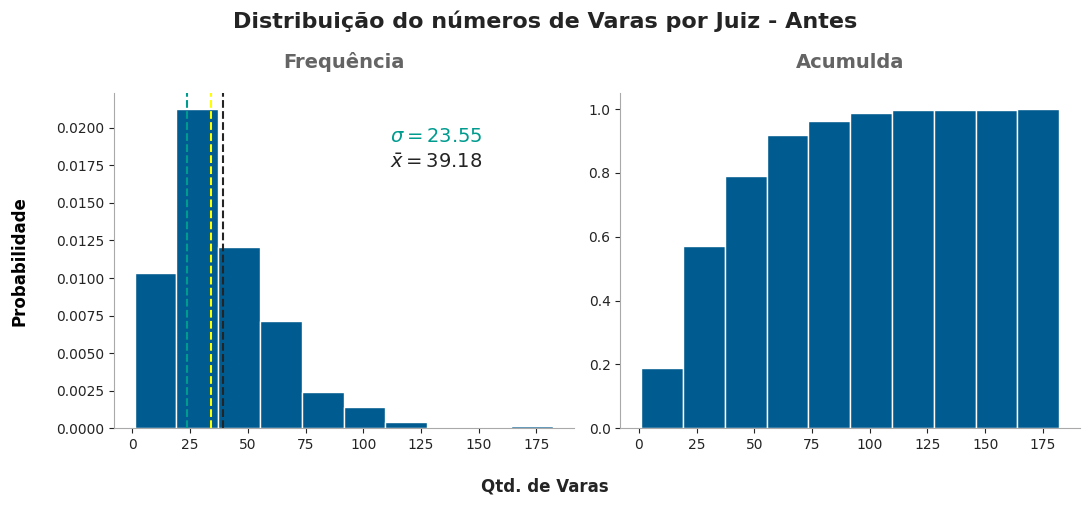

In [161]:
# Gráfico da distribuição do némero de varas por juiz (antes)
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('Distribuição do números de Varas por Juiz - Antes', fontweight='bold', fontsize=16, color=cinza3)
fig.subplots_adjust(top=0.80)

ax1.set_title('Frequência', fontweight='bold', fontsize=14, y=1.05, color=cinza2)
ax1.set_ylabel('Probabilidade', fontweight='bold', labelpad=20, fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(cinza1)
ax1.spines['bottom'].set_color(cinza1)
ax1.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax1.tick_params(axis='y', labelsize=10, colors=cinza3)
n, bins, patches = ax1.hist(juiz_x_vara['Aloc. Vara (antes)'], density=True, edgecolor='white', color=tjba_azul)
ax1.axvline(juiz_x_vara['Aloc. Vara (antes)'].mean(), color=cinza3, linestyle='--', label='Média')
ax1.axvline(juiz_x_vara['Aloc. Vara (antes)'].median(), color="yellow", linestyle='--', label='Mediana')
ax1.axvline(juiz_x_vara['Aloc. Vara (antes)'].std(), color=tjba_verde, linestyle='--', label='Desvio Padrão')
ax1.text(0.6, 0.90, rf"$\sigma = {juiz_x_vara['Aloc. Vara (antes)'].std():.2f}$", 
        transform=ax1.transAxes, fontsize=14, va="top", color=tjba_verde)
ax1.text(0.6, 0.82, rf"$\bar{{x}} = {juiz_x_vara['Aloc. Vara (antes)'].mean():.2f}$", 
        transform=ax1.transAxes, fontsize=14, va="top", color=cinza3)

ax2.set_title('Acumulda', fontweight='bold', fontsize=14, y=1.05, color=cinza2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(cinza1)
ax2.spines['bottom'].set_color(cinza1)
ax2.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax2.tick_params(axis='y', labelsize=10, colors=cinza3)
ax2.hist(juiz_x_vara['Aloc. Vara (antes)'], density=True, cumulative=True, edgecolor='white', color=tjba_azul)

fig.supxlabel('Qtd. de Varas', fontweight='bold', fontsize=12, color=cinza3, y=0.01) 

plt.tight_layout()
plt.show()

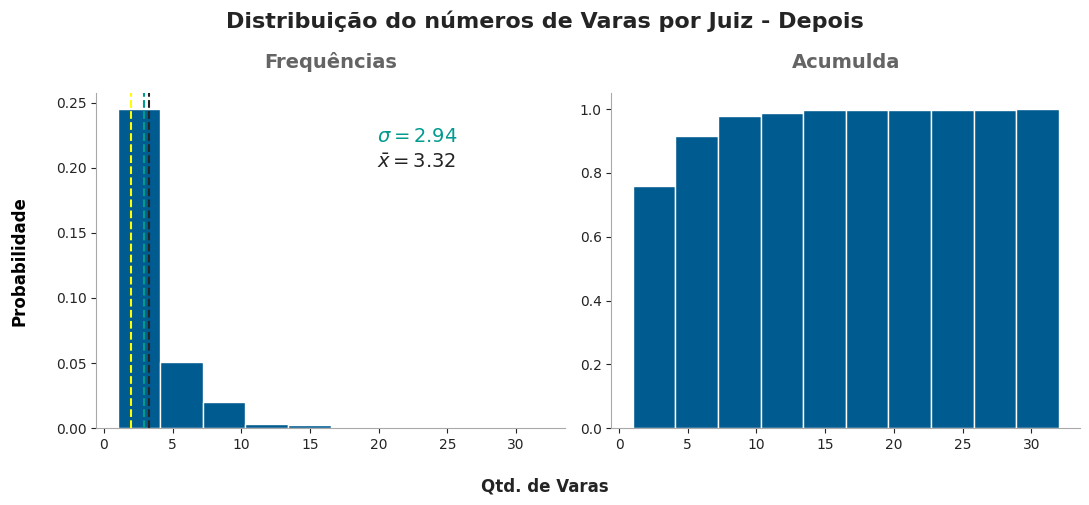

In [163]:
# Gráfico da distribuição do némero de varas por juiz (depois)
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('Distribuição do números de Varas por Juiz - Depois', fontweight='bold', fontsize=16, color=cinza3)
fig.subplots_adjust(top=0.80)

ax1.set_title('Frequências', fontweight='bold', fontsize=14, y=1.05, color=cinza2)
ax1.set_ylabel('Probabilidade', fontweight='bold', labelpad=20, fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(cinza1)
ax1.spines['bottom'].set_color(cinza1)
ax1.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax1.tick_params(axis='y', labelsize=10, colors=cinza3)
n, bins, patches = ax1.hist(juiz_x_vara['Aloc. Vara (depois)'], density=True, edgecolor='white', color=tjba_azul)
ax1.axvline(juiz_x_vara['Aloc. Vara (depois)'].mean(), color=cinza3, linestyle='--', label='Média')
ax1.axvline(juiz_x_vara['Aloc. Vara (depois)'].median(), color="yellow", linestyle='--', label='Mediana')
ax1.axvline(juiz_x_vara['Aloc. Vara (depois)'].std(), color=tjba_verde, linestyle='--', label='Desvio Padrão')
ax1.text(0.6, 0.90, rf"$\sigma = {juiz_x_vara['Aloc. Vara (depois)'].std():.2f}$", 
        transform=ax1.transAxes, fontsize=14, va="top", color=tjba_verde)
ax1.text(0.6, 0.82, rf"$\bar{{x}} = {juiz_x_vara['Aloc. Vara (depois)'].mean():.2f}$", 
        transform=ax1.transAxes, fontsize=14, va="top", color=cinza3)

ax2.set_title('Acumulda', fontweight='bold', fontsize=14, y=1.05, color=cinza2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(cinza1)
ax2.spines['bottom'].set_color(cinza1)
ax2.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax2.tick_params(axis='y', labelsize=10, colors=cinza3)
ax2.hist(juiz_x_vara['Aloc. Vara (depois)'], density=True, cumulative=True, edgecolor='white', color=tjba_azul)

fig.supxlabel('Qtd. de Varas', fontweight='bold', fontsize=12, color=cinza3, y=0.01) 

plt.tight_layout()
plt.show()

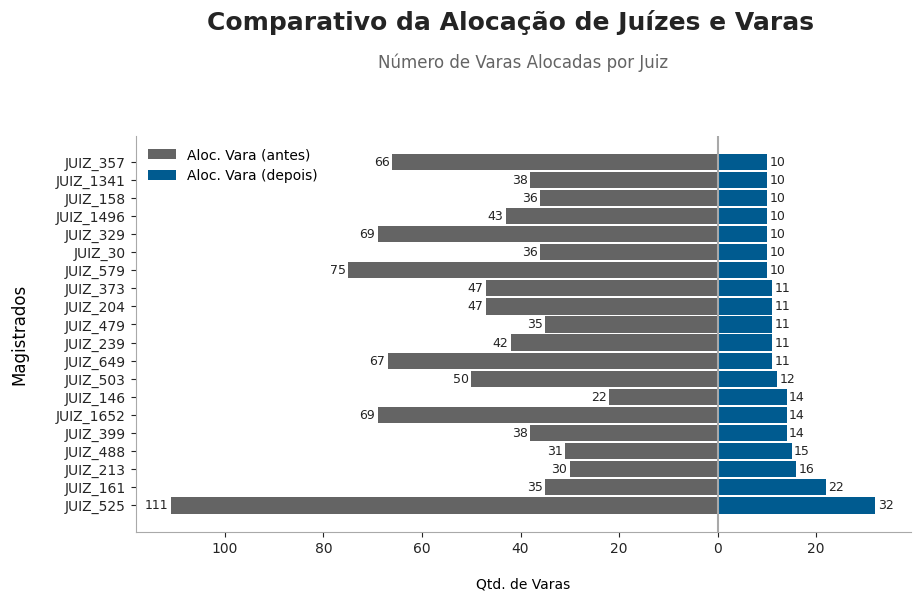

In [164]:
# Gráfico compartivo da alocação de juízes e varas

# Aplica style default
plt.style.use('default')

# Cria objeto para o plot
fig, ax = plt.subplots(figsize=(10,6))

# Criar espaço entre suptitle e set_title
fig.subplots_adjust(top=0.77)

# Titulos e subtitulos
fig.suptitle('Comparativo da Alocação de Juízes e Varas', fontweight='bold', fontsize=18, color=cinza3)
ax.set_title('Número de Varas Alocadas por Juiz', y=1.15, color=cinza2)
ax.set_ylabel('Magistrados', labelpad=20, fontsize=12)
ax.set_xlabel("\nQtd. de Varas")

#
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{abs(x):g}"))

# Retiea bordas dos eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Eixo Y (nomes)
#y = range(len(juiz_x_vara))
qtd_ref = 20
y = range(20)

# Linha central no zero
ax.axvline(0, color=cinza1)

# Barras
ax.barh(y, -juiz_x_vara.iloc[0:qtd_ref, 2], color=cinza2, label="Aloc. Vara (antes)", height=0.9)
ax.barh(y, juiz_x_vara.iloc[0:qtd_ref, 1], color=tjba_azul, label="Aloc. Vara (depois)", height=0.9)

# Ajusta os ticks do eixo Y
ax.set_yticks(y)
ax.set_yticklabels(juiz_x_vara.iloc[0:qtd_ref, 0])

# Muda cor dos eixos
ax.spines['left'].set_color(cinza1)
ax.spines['bottom'].set_color(cinza1)

# Aumentar o tamanho da fonte das marcas no eixo X
ax.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax.tick_params(axis='y', labelsize=10, colors=cinza3)

# Coloca legenda
ax.legend(edgecolor='none')

# Adiciona os valores nas barras (antes - esquerda)
for i, v in enumerate(juiz_x_vara.iloc[0:qtd_ref, 2]):
    ax.text(-v - 0.5, i, str(v), va='center', ha='right', color=cinza3, fontsize=9)

# Adiciona os valores nas barras (depois - direita)
for i, v in enumerate(juiz_x_vara.iloc[0:qtd_ref, 1]):
    ax.text(v + 0.5, i, str(v), va='center', ha='left', color=cinza3, fontsize=9)

#plt.tight_layout()
plt.show()

## Conclusão

O fato do modelo ter encontrado uma solução ótima significa que o **modelo conseguiu alocar 100% da capacidade produtiva de todos os juízes disponíveis sem violar nenhuma das restrições do sistema**.

**Então, onde está o 'ganho' do modelo?**

O ganho não está em "criar" mais produtividade do que a existente, o que é impossível. O ganho está em provar que é possível atingir a produtividade máxima de uma forma mais organizada, equilibrada e eficiente do que a forma como ela está distribuída atualmente.

A **"mágica"** do modelo não está no valor final da Função Objetivo (neste caso), mas na nova configuração das variáveis $x_{i,j}$ **(a distribuição de juízes nas varas)**. A solução ótima do modelo, apesar de ter o mesmo valor de produtividade total, representa uma alocação superior por várias razões:

* **Atendimento à Demanda:** A alocação histórica (a real) pode não estar atendendo à demanda específica de cada vara. A sua nova distribuição garante que a produtividade alocada para cada especialidade na vara seja suficiente para cobrir a demanda ponderada ( $D_{j,k,t}$ ). A alocação anterior provavelmente não cumpria isso em todas as varas.

* **Respeito à Capacidade da Vara:** Historicamente, algumas varas podem estar sobrecarregadas, com uma carga de trabalho total maior do que sua capacidade ( $C_{j,t}$ ). O modelo moveu juízes para garantir que a produtividade total alocada a uma vara não exceda sua capacidade máxima.

* **Equilíbrio da Carga de Trabalho:** O resultado prático do ponto anterior é um sistema mais equilibrado. O modelo provavelmente tirou "pressão" de varas superlotadas e utilizou a capacidade de varas que estavam ociosas, promovendo um equilíbrio mais justo na carga de trabalho.

* **Alocação Correta por Especialização:** O modelo garantiu que 100% das alocações respeitassem a especialização do juiz. Na prática, a alocação histórica pode ter tido inconsistências que a sua solução ótima corrigiu.

* **Respeito aos Limites Físicos:** A sua solução garante que nenhuma vara tenha mais juízes do que o seu máximo histórico ( $M_{j,t}$ ).

O modelo provou que é possível manter a produtividade máxima do sistema (utilizar 100% da força de trabalho dos juízes) e, ao mesmo tempo, organizar a distribuição dessa força de trabalho para respeitar todas as regras operacionais e demandas do judiciário. O valor do modelo não está no aumento da produtividade (pois ela já estava no teto), mas a otimização da distribuição, gerando mais equilíbrio e eficiência operacional. 